In [58]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import iris
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy.crs as ccrs
import iris.analysis.calculus as calculus
from iris.coord_categorisation import add_year, add_month_number, add_day_of_month, add_day_of_year
import pandas as pd
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks
import datetime
import matplotlib.colors as colors
import glob
%matplotlib 

Using matplotlib backend: Qt5Agg


In [124]:
def derivative(cube, axisname):
    R = 6378388.  # Radius of the earth
    deg2rad = 0.0174533  # pi/180.
    dcube = cube.copy()

    coord_names = np.array([c.var_name for c in cube.coords()])
    # print(coord_names)

    if axisname == 'latitude':
        lats = cube.coord('latitude').points
        axis_index = np.where(coord_names == 'latitude')[0][0]
        dlat = np.diff(lats) * deg2rad  # convert to radians
        dy = R * np.sin(dlat)  # constant at this latitude
        dcube = calculus.differentiate(cube, 'latitude')
        dcube /= iris.util.broadcast_to_shape(dy, dcube.shape, (axis_index,))

    if axisname == 'longitude':
        lats = cube.coord('latitude').points
        lons = cube.coord('longitude').points
        axis_index = np.where(coord_names == 'latitude')[0][0]
        dlon = (lons[1] - lons[0]) * deg2rad  # convert to radians
        dx = np.array([R * np.cos(deg2rad * lat) * dlon for lat in lats])
        dcube = calculus.differentiate(cube, 'longitude')
        dcube /= iris.util.broadcast_to_shape(dx, dcube.shape, (axis_index,))
    return dcube

In [2]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.

    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

def lanczos_filter(cube, window=101, low=1./100., high=1./20.):
    wgts_high = low_pass_weights(window, high)
    wgts_low = low_pass_weights(window, low)
    cube_filt = cube.copy()
    cube_filt.data = np.apply_along_axis(lambda m: (np.convolve(m, wgts_high, mode='same') - 
                            np.convolve(m, wgts_low, mode='same')), axis=0, arr=cube.data)
    return cube_filt

In [61]:
def prepare_calendar(cube):
    # Setting up the dates on data
    if not cube.coords('year'):
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    if not cube.coords('month_number'):
        iris.coord_categorisation.add_month_number(cube, 'time', name='month_number')
    if not cube.coords('day_of_month'):
        iris.coord_categorisation.add_day_of_month(cube, 'time', name='day_of_month')
    if not cube.coords('day_of_year'):
        iris.coord_categorisation.add_day_of_year(cube, 'time', name='day_of_year')
    return cube

def return_indices_of_a(a, b):
  b_set = set(b)
  return [int(i) for i, v in enumerate(a) if v in b_set]

In [4]:
def find_nearest_in_list(myList, myNumber):
    return min(myList, key=lambda x: abs(x - myNumber))

def get_cube_coords_along_line(cube, start_coords=None, end_coords=None):
    '''
    Generate a (lat,lon) pair of cube coordinates along a line
    made up of start and end points
    :param cube: iris cube with (lat, lon) coordinates
    :type cube:
    :param start_coords: (lat, lon)
    :type start_coords:
    :param end_coords: (lat, lon)
    :type end_coords:
    :return: lists of lats, lons along the path
    :rtype:
    '''
    if not (start_coords is None) or (end_coords is None):
        lons = cube.coord('longitude').points
        lats = cube.coord('latitude').points

        # Find the actual coordinate values between the points
        lat1, lon1 = start_coords
        lat2, lon2 = end_coords
        if lon1 < lon2:
            r_lons = lons[(lon1 < lons) & (lons <= lon2)]
        else:
            r_lons = lons[(lon2 < lons) & (lons <= lon1)][::-1]

        if lat1 < lat2:
            r_lats = lats[(lat1 < lats) & (lats <= lat2)]
        else:
            r_lats = lats[(lat2 < lats) & (lats <= lat1)][::-1]

        # Generate a line from start to end points
        # slope of the line y = mx + b
        # m = slope = (y1-y2)/(x1-x2)
        m = (r_lats[-1] - r_lats[0]) / (r_lons[-1] - r_lons[0])

        # b = y-intercept = (x1*y2 - x2*y1)/(x1-x2)
        b = (r_lons[0] * r_lats[-1] - r_lons[-1] * r_lats[0]) / (r_lons[0] - r_lons[-1])

        # lat points for all lon points along the line
        ys = [m * x + b for x in r_lons]

        # get the corresponding lat values from the coordinate list
        ys_lats = [find_nearest_in_list(lats, yy) for yy in ys]

        return ys_lats, r_lons
    else:
        print('Start/End coordinates missing.')


def cross_section_along_path(cube, lons=None, lats=None):
    cross_section = []
    # Extracting each point and appending
    for ylat, xlon in zip(lats, lons):
        cross_section.append(cube.extract(iris.Constraint(latitude=ylat, longitude=xlon)))

    # merging to a single cube
    # longitude values is given as aux coordinate
    return iris.cube.CubeList(cross_section).merge_cube()

In [5]:
def read_GPM():
    file_names = glob.glob('/project/MJO_GCSS/hadgem3/data/obs/GPM/gpm_imerg_24h_mean_????????.nc')
    cubes = []
    for file_name in file_names:
        cube = iris.load_cube(file_name)
        cubes.append(cube.intersection(longitude=(90, 130), latitude=(-10,25)))
    return cubes

In [62]:
#precip_cube = iris.load_cube('/project/MJO_GCSS/hadgem3/data/obs/SEAPy_data/obs/obs_PRECIP.pp.nc')
precip_cube = iris.load_cube('/project/MJO_GCSS/SoutheastAsia_data/TRMM/daily/3B42_daily.1998_2012_Global.nc')
#precip_cube = iris.load_cube('/project/MJO_GCSS/hadgem3/data/obs/GPM_SEA_24h_mean_2000_2020.nc')
precip_cube = precip_cube.intersection(longitude=(90, 130), latitude=(-10,25))

#precip_cube = read_GPM()
#iris.cube.CubeList(precip_cube).merge()
precip_cube = prepare_calendar(precip_cube)

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1940: UserWarning: Skipping global attribute 'calendar': 'calendar' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))


In [72]:
precip_cube

Daily (0Z-21Z) Rainfall Total (mm),time,latitude,longitude
Shape,5479,140,160
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
day_of_month,x,-,-
day_of_year,x,-,-
month_number,x,-,-
year,x,-,-


In [74]:
precip_daily_climate = precip_cube.aggregated_by(['month_number'],iris.analysis.MEAN)
#precip_daily_climate

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/cube.py:3218: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


In [82]:
plt.subplot(211)
precip_daily_climate_ts = precip_daily_climate.intersection(longitude=(95, 115), latitude=(-10,15)).collapsed(('latitude', 'longitude'), iris.analysis.MEAN)
plt.bar(range(1,13), precip_daily_climate_ts.data)
plt.title('95-115E, 10S-15N')

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/cube.py:3218: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


Text(0.5, 1.0, '95-115E, 10S-15N')

In [134]:
u850_cube = iris.load_cube('/project/MJO_GCSS/hadgem3/data/obs/SEAPy_data/obs/obs_U850.pp.nc')
u850_cube = u850_cube.intersection(longitude=(90, 130), latitude=(-10,25))
#u850_cube = prepare_calendar(u850_cube)
v850_cube = iris.load_cube('/project/MJO_GCSS/hadgem3/data/obs/SEAPy_data/obs/obs_V850.pp.nc')
v850_cube = v850_cube.intersection(longitude=(90, 130), latitude=(-10,25))
#v850_cube = prepare_calendar(v850_cube)
## U and V are on different grids
#u850_cube = u850_cube.regrid(v850_cube, scheme=iris.analysis.Linear())

In [68]:
u850_cube.coord('longitude').points

array([ 90. ,  92.5,  95. ,  97.5, 100. , 102.5, 105. , 107.5, 110. ,
       112.5, 115. , 117.5, 120. , 122.5, 125. , 127.5, 130. ])

In [141]:
div_cube = derivative(u850_cube, 'longitude')#.regrid(u850_cube, iris.analysis.Linear())
print(div_cube.shape)
div_cube = derivative(v850_cube, 'latitude')#.regrid(u850_cube, iris.analysis.Linear())
print(div_cube.shape)

(7305, 15, 16)
(6209, 35, 41)


In [150]:
u850_cube.var_name, u850_cube.standard_name, u850_cube.name

('u',
 'eastward_wind',
 <bound method CFVariableMixin.name of <iris 'Cube' of eastward_wind / (m s**-1) (time: 7305; latitude: 15; longitude: 17)>>)

In [129]:
qplt.pcolormesh(div_cube[0])

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


In [9]:
precip_cube_filt = lanczos_filter(precip_cube, window=101, low=1./90., high=1./20.)
#u850_cube_filt = lanczos_filter(u850_cube, window=101, low=1./90., high=1./20.)
#v850_cube_filt = lanczos_filter(v850_cube, window=101, low=1./90., high=1./20.)

In [22]:
def create_dates_df(cube):
    cube = prepare_calendar(cube)
    cube_dates_df = pd.concat([pd.DataFrame(cube.coord('year').points),
                          pd.DataFrame(cube.coord('month_number').points), 
                          pd.DataFrame(cube.coord('day_of_month').points)], axis=1)
    cube_dates_df.columns = ['year', 'month', 'day']
    return cube_dates_df

precip_cube_dates_df = create_dates_df(precip_cube)
#u850_cube_dates_df = create_dates_df(u850_cube)
#v850_cube_dates_df = create_dates_df(v850_cube)

In [332]:
v850_cube_dates_df

,year,month,day
0,1998,1,1
1,1998,1,2
2,1998,1,3
3,1998,1,4
4,1998,1,5
...,...,...,...
6204,2014,12,27
6205,2014,12,28
6206,2014,12,29
6207,2014,12,30


Plot summer variance and fraction of filtered

In [12]:
def precip_var_ratio_season(precip_cube, precip_cube_filt, season_months = [5,6,7,8, 9, 10]):
    precip_cube_dates_df = create_dates_df(precip_cube)
    season_df = precip_cube_dates_df.loc[(precip_cube_dates_df['month'].isin(season_months))]
    seasonal_variance = precip_cube[season_df.index].collapsed('time', iris.analysis.VARIANCE)
    seasonal_filt_variance = precip_cube_filt[season_df.index].collapsed('time', iris.analysis.VARIANCE)
    return seasonal_variance, seasonal_filt_variance

In [204]:
def make_composite(cube, inds, lag=20):
    # Get a mid value of the number of indices
    if len(inds)>3:
        n2 = 3
    comp_cube = cube[inds[n2]-lag:inds[n2]+lag+1].copy()
    comp_data = []
    for ind in inds:
        try:
            comp_data.append(cube[ind-lag:ind+lag+1].data)
        except:
            print('No date found. Skip')
            pass        
    comp_cube.data = np.ma.mean(np.array(comp_data), axis=0)
    return comp_cube

In [83]:
#tsff = np.convolve(ts.data, wgts_high, mode='same') - np.convolve(ts.data, wgts_low, mode='same')
summer_var, summer_filt_var = precip_var_ratio_season(precip_cube, precip_cube_filt, season_months = [5,6,7,8, 9, 10])
winter_var, winter_filt_var = precip_var_ratio_season(precip_cube, precip_cube_filt, season_months = [1,2,3,4,11,12])

NameError: name 'precip_var_ratio_season' is not defined

In [232]:
def plot_variance_ratio(runid='obs'):
    # Out Plot Directory
    out_plot_dir = '/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs'
    #os.path.join(data_paths.dirs('data_out_dir'), runid)
    precip_mean = iris.load_cube(os.path.join(out_plot_dir, 'obs_MJJAS_precipitation_flux_mean.nc'))
    
    plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    levels = np.arange(4, 44, 4)
    cmap = plt.get_cmap('GnBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    cf = iplt.pcolormesh(precip_mean, cmap=cmap, norm=norm)
    plt.gca().coastlines()
    plt.colorbar(cf, orientation='vertical')
    plt.ylim([-10, 25])
    plt.xlim([90, 130])
    gl = ax.gridlines(draw_labels=True, alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    plt.show()
    

In [233]:
plot_variance_ratio()

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


In [185]:
#inds = cube_dates_df.loc[(cube_dates_df['month'].isin([5,6,7,8, 9, 10, 11, 12])) & (cube_dates_df['year'] ==2002)].index

In [19]:
area_ts = precip_cube_filt.intersection(longitude=(100, 105), latitude=(5,10))
area_ts = area_ts.collapsed( ('latitude', 'longitude'), iris.analysis.MEAN)

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/cube.py:3218: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


In [20]:
#qplt.plot(area_ts)
ts_std = (area_ts.data - np.ma.mean(area_ts.data))/np.ma.std(area_ts.data)

# Find peaks above 1 stdev
peaks, _ = find_peaks(ts_std, height=0.75)

In [21]:
# all summer seasons
season_months = [5,6,7,8, 9, 10]
season_df = precip_cube_dates_df.loc[(precip_cube_dates_df['month'].isin(season_months))]

# select peaks in summer alone
peaks_df = precip_cube_dates_df.loc[peaks]
peaks_df = peaks_df.loc[(peaks_df['month'].isin(season_months))]
#peaks_df

In [330]:
def make_dates_from_df(df):
    return [year*10000+month*100+day for year, month, day in zip(df.year, df.month, df.day)]

In [333]:
peaks_dates = make_dates_from_df(peaks_df)
precip_dates = make_dates_from_df(precip_cube_dates_df)
u850_dates = make_dates_from_df(u850_cube_dates_df)
v850_dates = make_dates_from_df(v850_cube_dates_df)

precip_matching_inds = return_indices_of_a(precip_dates, peaks_dates)
u850_matching_inds = return_indices_of_a(u850_dates, peaks_dates)
v850_matching_inds = return_indices_of_a(v850_dates, peaks_dates)

In [341]:
len(u850_dates), len(v850_dates), len(precip_dates)

(7305, 6209, 5479)

In [335]:
print(len([precip_dates[idx] for idx in precip_matching_inds]), 
      len([u850_dates[idx] for idx in u850_matching_inds]), 
      len([v850_dates[idx] for idx in v850_matching_inds]))

57 41 57


In [195]:
precip_comp = make_composite(precip_cube, precip_matching_inds, lag=25)
precip_comp_filt = make_composite(precip_cube_filt, precip_matching_inds, lag=25)

In [211]:
u850_comp = make_composite(u850_cube, u850_matching_inds, lag=25)
u850_comp_filt = make_composite(u850_cube_filt, u850_matching_inds, lag=25)
v850_comp = make_composite(v850_cube, v850_matching_inds, lag=25)
v850_comp_filt = make_composite(v850_cube_filt, v850_matching_inds, lag=25)

In [38]:
precip_comp = iris.load_cube('/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_ISO_lead_lag_precipitation_flux_composite.nc')
precip_comp_filt = iris.load_cube('/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_ISO_lead_lag_precipitation_flux_filt_composite.nc')
u850_comp = iris.load_cube('/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_ISO_lead_lag_x_wind_850_composite.nc')
u850_comp_filt = iris.load_cube('/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_ISO_lead_lag_x_wind_850_filt_composite.nc')
v850_comp = iris.load_cube('/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_ISO_lead_lag_y_wind_850_composite.nc')
v850_comp_filt = iris.load_cube('/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_ISO_lead_lag_y_wind_850_filt_composite.nc')

sst_comp = iris.load_cube('/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_ISO_lead_lag_sst_composite.nc')
sst_comp_filt = iris.load_cube('/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_ISO_lead_lag_sst_filt_composite.nc')

vort850_comp = iris.load_cube('/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_ISO_lead_lag_vorticity_850_composite.nc')
vort850_comp_filt = iris.load_cube('/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_ISO_lead_lag_vorticity_850_filt_composite.nc')

div850_comp = iris.load_cube('/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_ISO_lead_lag_divergence_850_composite.nc')
div850_comp_filt = iris.load_cube('/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_ISO_lead_lag_divergence_850_filt_composite.nc')

In [39]:
precip_comp_hov = precip_comp.intersection(longitude=(100, 120), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)
precip_comp_filt_hov = precip_comp_filt.intersection(longitude=(100, 120), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)

u850_comp_hov = u850_comp.intersection(longitude=(100, 120), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)
u850_comp_filt_hov = u850_comp_filt.intersection(longitude=(100, 120), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)

v850_comp_hov = v850_comp.intersection(longitude=(100, 120), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)
v850_comp_filt_hov = v850_comp_filt.intersection(longitude=(100, 120), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)

sst_comp_hov = sst_comp.intersection(longitude=(100, 120), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)
sst_comp_filt_hov = sst_comp_filt.intersection(longitude=(100, 120), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)

vort850_comp_hov = vort850_comp.intersection(longitude=(100, 120), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)
vort850_comp_filt_hov = vort850_comp_filt.intersection(longitude=(100, 120), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)

div850_comp_hov = div850_comp.intersection(longitude=(100, 120), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)
div850_comp_filt_hov = div850_comp_filt.intersection(longitude=(100, 120), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environmen

In [40]:
ntime, nlat = div850_comp_filt_hov.shape

In [41]:
lag = int(ntime/2)
lag

25

In [42]:
fig = plt.figure(1, figsize=(12, 7), dpi=100)

plt.subplot(121)
times = np.arange(-lag, lag+1, 1)
lats = precip_comp_filt_hov.coord('latitude').points
T, L = np.meshgrid(times, lats)
CS = plt.contourf(T, L, precip_comp_filt_hov.data.T, levels=np.linspace(-10, 10, 11), cmap='RdBu', extend='both')
plt.colorbar(CS)

lats = vort850_comp_filt_hov.coord('latitude').points
T, L = np.meshgrid(times, lats)
CS1 = plt.contour(T, L, vort850_comp_filt_hov.data.T*1e5, levels=np.linspace(-5, 5, 11), colors='k')
plt.gca().clabel(CS1, inline=True, fontsize=10, fmt='%1.1f')
plt.contour(T, L, vort850_comp_filt_hov.data.T*1e5, levels=[0], colors='k', linewidths=[3])

plt.ylabel('Latitude')
plt.xlabel('Lead/Lag (days)')
plt.title('Precip., 850hPa vorticity (*1e5) [95-110E]')

plt.subplot(122)
times = np.arange(-lag, lag+1, 1)
lats = precip_comp_filt_hov.coord('latitude').points
T, L = np.meshgrid(times, lats)
CS = plt.contourf(T, L, precip_comp_filt_hov.data.T, levels=np.linspace(-10, 10, 11), cmap='RdBu', extend='both')
plt.colorbar(CS)

lats = div850_comp_filt_hov.coord('latitude').points
T, L = np.meshgrid(times, lats)
CS1 = plt.contour(T, L, div850_comp_filt_hov.data.T*1e5, levels=np.linspace(-1, 1, 11), colors='k')
plt.gca().clabel(CS1, inline=True, fontsize=10, fmt='%1.1f')
plt.contour(T, L, div850_comp_filt_hov.data.T*1e5, levels=[0], colors='k', linewidths=[3])

plt.ylabel('Latitude')
plt.xlabel('Lead/Lag (days)')
plt.title('Precip., 850hPa divergence (*1e5) [95-110E]')

Text(0.5, 1.0, 'Precip., 850hPa divergence (*1e5) [95-110E]')

In [43]:

#times = precip_comp_hov.coord('time').points
#
lag = 25
fig = plt.figure(2, figsize=(12, 7), dpi=100)
plt.subplot(121)
times = np.arange(-lag, lag+1, 1)
lats = precip_comp_hov.coord('latitude').points
T, L = np.meshgrid(times, lats)
CS = plt.contourf(T, L, precip_comp_hov.data.T, levels=np.linspace(5, 40, 11), cmap='YlGnBu', extend='max')
plt.colorbar(CS)
#qplt.contour(u850_comp_filt_hov, levels=np.linspace(-5, 5, 11), colors='k')
t = times
y = u850_comp_hov.coord('latitude').points

u = u850_comp_hov.data.T
v = v850_comp_hov.data.T
speed = np.sqrt(u**2+v**2)
lw = speed/5  # an adhoc scaling for plotting

# Bounds for streamplot
bounds = np.arange(0, 4, 1)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cl = plt.gca().streamplot(t, y, u, v, density=(2., 1.5), maxlength=1, cmap='GnBu',  norm=norm, color=speed, linewidth=lw)
#plt.gca().quiver(t, y, u, v, cmap='GnBu', alpha=0.5) 
plt.ylim([-10, 25])
plt.ylabel('Latitude')
plt.xlabel('Lead/Lag (days)')
plt.title('Precip., 850hPa winds [95-110E]')

plt.subplot(122)
lats = precip_comp_filt_hov.coord('latitude').points
T, L = np.meshgrid(times, lats)
CS = plt.contourf(T, L, precip_comp_filt_hov.data.T, levels=np.linspace(-10, 10, 11), cmap='RdBu', extend='max')
plt.colorbar(CS)

lats = sst_comp_filt_hov.coord('latitude').points
T, L = np.meshgrid(times, lats)
csc = plt.contour(T, L, sst_comp_filt_hov.data.T, levels=np.arange(-0.3, 0.4, 0.05), colors='k')
plt.gca().clabel(csc, inline=True, fontsize=10, fmt='%1.1f')
plt.contour(T, L, sst_comp_filt_hov.data.T, levels=[0], colors='k', linewidths=[3])
plt.ylim([-10, 25])
plt.ylabel('Latitude')
plt.xlabel('Lead/Lag (days)')
plt.title('Filtered precip., SST [95-110E]')


'''
#plt.contourf(precip_comp_hov.data, 
#qplt.contour(u850_comp_filt_hov, levels=np.linspace(-5, 5, 11), colors='k')
t = times
y = u850_comp_filt_hov.coord('latitude').points

print(u850_comp_hov.shape, v850_comp_hov.shape, t.shape)
u = u850_comp_filt_hov.data.T
v = v850_comp_filt_hov.data.T
speed = np.sqrt(u**2+v**2)
lw = speed  # an adhoc scaling for plotting


# Bounds for streamplot
bounds = np.arange(0, 4, 1)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cl = plt.gca().streamplot(t, y, u, v, density=(2., 1.5), maxlength=1, cmap='GnBu',  norm=norm, color=speed, linewidth=lw)
#plt.gca().quiver(t, y, u, v, cmap='GnBu', alpha=0.5)
plt.ylabel('Latitude')
plt.xlabel('Lead/Lag (days)')
plt.title('Filtered precip., 850hPa winds [95-110E]')
'''

"\n#plt.contourf(precip_comp_hov.data, \n#qplt.contour(u850_comp_filt_hov, levels=np.linspace(-5, 5, 11), colors='k')\nt = times\ny = u850_comp_filt_hov.coord('latitude').points\n\nprint(u850_comp_hov.shape, v850_comp_hov.shape, t.shape)\nu = u850_comp_filt_hov.data.T\nv = v850_comp_filt_hov.data.T\nspeed = np.sqrt(u**2+v**2)\nlw = speed  # an adhoc scaling for plotting\n\n\n# Bounds for streamplot\nbounds = np.arange(0, 4, 1)\nnorm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)\ncl = plt.gca().streamplot(t, y, u, v, density=(2., 1.5), maxlength=1, cmap='GnBu',  norm=norm, color=speed, linewidth=lw)\n#plt.gca().quiver(t, y, u, v, cmap='GnBu', alpha=0.5)\nplt.ylabel('Latitude')\nplt.xlabel('Lead/Lag (days)')\nplt.title('Filtered precip., 850hPa winds [95-110E]')\n"

In [245]:
np.linspace(-0.3, 0.3, 7)

array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3])

In [306]:
l = 25
plt.subplot(111)
qplt.contourf(precip_comp_filt[l], levels=np.linspace(-10, 10, 11), cmap='RdBu', extend='both')
plt.gca().coastlines()

x = u850_comp.coord('longitude').points
y = u850_comp.coord('latitude').points

speed = np.sqrt(u850_comp_filt[l].data**2+v850_comp_filt[l].data**2)
lw = speed  # an adhoc scaling for plotting

u = u850_comp_filt[l].data
v = v850_comp_filt[l].data
plt.quiver(x, y, u, v) 
# Bounds for streamplot
bounds = np.arange(2, 22, 2)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#cl = plt.gca().streamplot(x, y, u, v, density=(2., 1.5), maxlength=2)#, norm=norm, cmap='GnBu',  color=speed, linewidth=lw)

In [176]:
u850_comp_filt.shape, v850_comp_filt.shape

((51, 36, 41), (51, 36, 41))

In [295]:
def create_dates_df(cube):
    cube = prepare_calendar(cube)
    cube_dates_df = pd.concat([pd.DataFrame(cube.coord('year').points),
                          pd.DataFrame(cube.coord('month_number').points),
                          pd.DataFrame(cube.coord('day_of_month').points)], axis=1)
    cube_dates_df.columns = ['year', 'month', 'day']
    return cube_dates_df

In [303]:
def return_indices_of_adf(adf, bdf):
    a = [year*10000+month*100+day for year, month, day in zip(adf.year, adf.month, adf.day)]
    b = [year*10000+month*100+day for year, month, day in zip(bdf.year, bdf.month, bdf.day)]
    
    b_set = set(b)
    return [int(i) for i, v in enumerate(a) if v in b_set]
    

In [311]:
def compute_percentiles(cube, indices, percent=95):
    # compute percentiles
    percentiles = cube[indices].collapsed('time', iris.analysis.PERCENTILE, percent=percent)
    return percentiles

In [312]:
def bsiso_percentiles(runid=None, varname=None, write_out=True, percent=[95]):
    #data_root = os.path.join(run['data_retrieve_dir'], runid)
    data_root = '/project/MJO_GCSS/hadgem3/data/obs/SEAPy_data/obs'
    # Out Plot Directory
    #out_plot_dir = os.path.join(data_paths.dirs('data_out_dir'), runid)
    out_plot_dir = '/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs'

    # CSV file with dates of peak ISO phases
    bsiso_peak_dates_file = os.path.join(out_plot_dir, '%s_BSISO_peak_dates.csv' % runid)
    season_dates_file = os.path.join(out_plot_dir, '%s_MJJAS_season_dates.csv' % runid)
    
    file_name = os.path.join(data_root, 'GPM_PRECIP_SEA_24h_mean_2000_2020.nc')
    cube = iris.load_cube(file_name)
    
    peaks_dates_df = pd.read_csv(bsiso_peak_dates_file)
    season_dates_df = pd.read_csv(season_dates_file)
    
    #cube_dates_df = bsiso_utils.create_dates_df(cube)
    cube_dates_df = create_dates_df(cube)
    
    season_inds = return_indices_of_adf(cube_dates_df, season_dates_df) 
    peak_inds = return_indices_of_adf(cube_dates_df, peaks_dates_df) 
    
    for per in percent:
        peak_extreme_cube = compute_percentiles(cube, peak_inds, percent=per)
        season_extreme_cube = compute_percentiles(cube, season_inds, percent=per)

        #out_plot_dir = os.path.join(data_paths.dirs('data_out_dir'), runid)
        writeout_file = os.path.join(out_plot_dir,
                                     '%s_MJJAS_%s_ISO_peak_percentile_%s.nc' % (runid, varname, per))
        iris.save(peak_extreme_cube, writeout_file)
        print('Written %s' % writeout_file)
        
        writeout_file = os.path.join(out_plot_dir,
                                     '%s_MJJAS_%s_seasonal_percentile_%s.nc' % (runid, varname, per))
        iris.save(season_extreme_cube, writeout_file)
        print('Written %s' % writeout_file)
        
        

In [14]:
out_plot_dir = '/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs'

# CSV file with dates of peak ISO phases
bsiso_peak_dates_file = os.path.join(out_plot_dir, '%s_BSISO_peak_dates.csv' % 'obs')
peaks_dates_df = pd.read_csv(bsiso_peak_dates_file)

In [28]:
days_around_peak = 3
inds  = np.arange(10)
inds_around_peak = []
for ind in inds:
    inds_around_peak.extend(list(np.arange(ind-days_around_peak,ind+days_around_peak)))
    inds_around_peak = [item for item in inds_around_peak if item >= 0]

In [44]:
peak_extreme_file = '/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_precipitation_flux_ISO_peak_95th_percentile.nc'
peak_extreme = iris.load_cube(peak_extreme_file)
seasonl_extreme_file = '/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_MJJAS_precipitation_flux_seasonal_95th_percentile.nc'
season_extreme = iris.load_cube(seasonl_extreme_file)

In [47]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
levels = np.arange(-50, 60, 10)
#levels = np.arange(0, 100, 10)
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
cf = iplt.pcolormesh(100*(peak_extreme-season_extreme)/season_extreme, cmap=cmap, norm=norm)
#cf = iplt.pcolormesh(season_extreme, cmap=cmap, norm=norm)
plt.gca().coastlines()
plt.colorbar(cf, orientation='vertical')
plt.ylim([-10, 25])
plt.xlim([90, 130])
gl = ax.gridlines(draw_labels=True, alpha=0.5)
gl.xlabels_top = False
gl.ylabels_right = False
plt.show()

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1193: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


In [209]:
x = np.array([1,2,3,4])
y = np.array([2,1,5,2])
m = np.ma.masked_where(y>2, y)
new_x = np.ma.masked_array(x, m.mask)
print(new_x)

[1 2 -- 4]


In [151]:
from tqdm import tqdm
inds = range(10)
inds
for i in tqdm():
    print(i)

100%|██████████| 10/10 [00:00<00:00, 10567.66it/s]

0
1
2
3
4
5
6
7
8
9


In [248]:
cube_hov = precip_cube.intersection(longitude=(95, 110), latitude=(-10,25))
cube_hov = cube_hov.collapsed('longitude', iris.analysis.MEAN)

cube_hov_filt = precip_cube_filt.intersection(longitude=(95, 110), latitude=(-10, 25))
cube_hov_filt = cube_hov_filt.collapsed('longitude', iris.analysis.MEAN)

#cube_hov = precip_cube_filt[inds].intersection(longitude=(90, 180), latitude=(0,10))
#cube_hov = cube_hov.collapsed('latitude', iris.analysis.MEAN)
qplt.contourf(cube_hov, levels=np.linspace(0, 20, 11), cmap='YlGnBu')
qplt.contour(cube_hov_filt, levels=np.linspace(0, 10, 11))#, cmap='Rd')

In [480]:
u850_dates_df = pd.concat([pd.DataFrame(u850_cube.coord('year').points),
                          pd.DataFrame(u850_cube.coord('month_number').points), 
                          pd.DataFrame(u850_cube.coord('day_of_month').points)], axis=1)
u850_dates_df.columns = ['year', 'month', 'day']
#inds = cube_dates_df.loc[(cube_dates_df['month'].isin([5,6,7,8, 9, 10, 11, 12])) & (cube_dates_df['year'] ==2002)].index

area_ts = u850_cube_filt.intersection(longitude=(100, 105), latitude=(5,10))
area_ts = area_ts.collapsed( ('latitude', 'longitude'), iris.analysis.MEAN)

#qplt.plot(area_ts)
ts_std = (area_ts.data - np.ma.mean(area_ts.data))/np.ma.std(area_ts.data)

# Find peaks above 1 stdev
peaks, _ = find_peaks(ts_std, height=1.)


/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/cube.py:3218: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))


In [251]:
# all summer seasons
season_months = [5,6,7,8, 9, 10]
season_df = cube_dates_df.loc[(cube_dates_df['month'].isin(season_months))]

# select peaks in summer alone
peaks_df = cube_dates_df.loc[peaks]
peaks_df = peaks_df.loc[(peaks_df['month'].isin(season_months))]
#peaks_df

NameError: name 'cube_dates_df' is not defined

In [527]:
peaks_dates = [year*10000+month*100+day for year, month, day in zip(peaks_df.year, peaks_df.month, peaks_df.day)]
precip_dates = [year*10000+month*100+day for year, month, day in zip(precip_cube_dates_df.year, 
                                                                     precip_cube_dates_df.month, 
                                                                     precip_cube_dates_df.day)]
precip_matching_inds = return_indices_of_a(precip_dates, peaks_dates)

In [528]:
u850_comp = make_composite(u850_cube, peaks_df.index, lag=25)
u850_comp_filt = make_composite(u850_cube_filt, peaks_df.index, lag=25)

precip_comp = make_composite(precip_cube, precip_matching_inds, lag=25)
precip_comp_filt = make_composite(precip_cube_filt, precip_matching_inds, lag=25)

In [486]:
cube_hov = u850_comp.intersection(longitude=(95, 110), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)
cube_hov_f = u850_comp_filt.intersection(longitude=(95, 110), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)
#qplt.contourf(cube_hov, levels=np.linspace(-20, 20, 11), cmap='YlGnBu')
qplt.contour(cube_hov_f, levels=np.linspace(-5, 5, 11), cmap='RdBu')

In [ ]:

inds = u850_dates_df.loc[u850_dates_df['month'].isin([5,6,7,8, 9, 10])].index
rlats, rlons = get_cube_coords_along_line(u850_cube, start_coords=(-10, 95), end_coords=(22, 120))

cube_cross_sect = cross_section_along_path(u850_cube[inds], lons=rlons, lats=rlats)
cube_filt_cross_sect = cross_section_along_path(u850_cube_filt[inds], lons=rlons, lats=rlats)
cube_cross_sect
#cube_hov = u850_cube[inds].intersection(longitude=(95, 110), latitude=(-10,25))
#cube_hov = cube_hov.collapsed('longitude', iris.analysis.MEAN)

cube_hov_filt = u850_cube_filt[inds].intersection(longitude=(95, 110), latitude=(-10, 25))
cube_hov_filt = cube_hov_filt.collapsed('longitude', iris.analysis.MEAN)

#cube_hov = precip_cube_filt[inds].intersection(longitude=(90, 180), latitude=(0,10))
#cube_hov = cube_hov.collapsed('latitude', iris.analysis.MEAN)
qplt.contourf(cube_filt_cross_sect, levels=np.linspace(-20, 20, 11), cmap='RdBu')
#qplt.contour(cube_hov_filt, levels=np.linspace(-10, 10, 11), cmap='RdBu')

In [418]:
area_ts = precip_cube_filt.intersection(longitude=(100, 105), latitude=(5,10))
area_ts = area_ts.collapsed( ('latitude', 'longitude'), iris.analysis.MEAN)

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/cube.py:3218: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))


In [420]:
#qplt.plot(area_ts)
ts_std = (area_ts.data - np.ma.mean(area_ts.data))/np.ma.std(area_ts.data)

# Find peaks above 1 stdev
peaks, _ = find_peaks(ts_std, height=1.)

In [421]:
# all summer seasons
season_df = cube_dates_df.loc[(cube_dates_df['month'].isin([5,6,7,8, 9, 10]))]

# select peaks in summer alone
peaks_df = cube_dates_df.loc[peaks]
peaks_df = peaks_df.loc[(peaks_df['month'].isin([5,6,7,8, 9,10]))]
peaks_df.index, season_df.index
#peaks_inds

(Int64Index([ 149,  177,  210,  303,  503,  574,  604,  660,  884,  960, 1034,
             1267, 1311, 1367, 1587, 1956, 2117, 2352, 2399, 2467, 2689, 2807,
             2851, 3061, 3407, 3458, 3548, 3581, 3813, 3860, 3904, 3947, 4162,
             4215, 4258, 4295, 4521, 4551, 4587, 4630, 4662, 4908, 4982, 5045,
             5299, 5407],
            dtype='int64'),
 Int64Index([ 120,  121,  122,  123,  124,  125,  126,  127,  128,  129,
             ...
             5408, 5409, 5410, 5411, 5412, 5413, 5414, 5415, 5416, 5417],
            dtype='int64', length=2760))

In [423]:
precip_comp = make_composite(precip_cube, peaks_df.index, lag=25)
precip_comp_filt = make_composite(precip_cube_filt, peaks_df.index, lag=25)

In [424]:
#precip_cube

In [425]:
cube_hov = precip_comp.intersection(longitude=(95, 110), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)
cube_hov_f = precip_comp_filt.intersection(longitude=(95, 110), latitude=(-10,25)).collapsed('longitude', iris.analysis.MEAN)

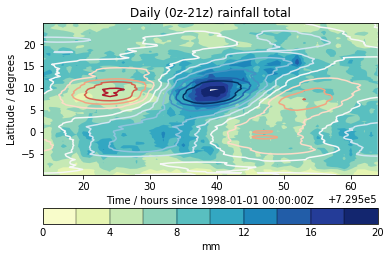

In [426]:
qplt.contourf(cube_hov, levels=np.linspace(0, 20, 11), cmap='YlGnBu')
qplt.contour(cube_hov_f, levels=np.linspace(-5, 5, 11), cmap='RdBu')

In [226]:
qplt.contourf(precip_comp_filt[30], levels=np.linspace(-5, 5, 11), cmap='RdBu', extend='both')
plt.gca().coastlines()

In [340]:
precip_summer_perc = compute_percentiles(precip_cube, season_inds.index, percent=[90])

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_month'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month_number'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


In [264]:
precip_iso_perc = compute_percentiles(precip_cube, peaks_inds.index-10, percent=[90])

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_month'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month_number'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


In [265]:
#qplt.contourf(precip_summer_perc95, levels=np.linspace(0, 30, 11), cmap='YlGnBu', extend='both')
qplt.contourf( 100.*(precip_iso_perc-precip_summer_perc)/precip_summer_perc, 
              levels=np.linspace(-100, 100, 11), cmap='RdBu', extend='both')
plt.gca().coastlines()

# Compute precip PDF for each country/region

In [250]:
#season_inds

In [354]:
def compute_percentiles(cube, indices, region=[(1.3,6.7),(100., 104.5)], percentiles=[5,25,50,75,95]):
    reg_data = cube[indices].intersection(latitude=region[0], longitude=region[1])
    return np.percentile(reg_data.data.ravel(),percentiles)

In [385]:
from sklearn.neighbors import KernelDensity
def compute_pdf(cube, indices, region=[(1.3,6.7),(100., 104.5)], bins=np.arange(0,200,10)):
    reg_data = cube[indices].intersection(latitude=region[0], longitude=region[1])
    # Plot the data using a normalized histogram
    hist, bin_edges = np.histogram(reg_data.data, bins=bins, density=True)
    plt.plot(bin_edges[1:], hist)

In [398]:
from scipy import stats
pen_malaysia = [(1.3,6.7),(100., 104.5)]
reg_data = precip_cube[season_inds.index].intersection(latitude=pen_malaysia[0], longitude=pen_malaysia[1])
bins=np.arange(0,200,5)
hist, bin_edges = np.histogram(reg_data.data, bins=bins, density=True)

# Do kernel density estimation
#kd = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(reg_data.data)
#compute_pdf(precip_cube, season_inds.index, region=pen_malaysia)

<BarContainer object of 39 artists>

In [407]:
data_mean = reg_data.data.mean()
data_std = reg_data.data.std()
distlognormal = stats.pearson3.pdf(bins, skew=3, loc=data_mean, scale=data_std)
distlognormal.shape
plt.plot(bin_edges[:-1], hist)
plt.plot(bin_edges, distlognormal)

In [249]:
pen_malaysia_season = compute_percentiles(precip_cube, season_inds.index, region=pen_malaysia, percentiles=[5,25,50,75,95, 99])
pen_malaysia_active = compute_percentiles(precip_cube, peaks_inds.index, region=pen_malaysia, percentiles=[5,25,50,75,95, 99])
pen_malaysia_break = compute_percentiles(precip_cube, peaks_inds.index+12, region=pen_malaysia, percentiles=[5,25,50,75,95, 99])

NameError: name 'compute_percentiles' is not defined

In [374]:
plt.plot([5,25,50,75,95, 99], pen_malaysia_season, 'black')
plt.plot([5,25,50,75,95, 99], pen_malaysia_active, 'red')
#plt.plot([5,25,50,75,95, 99], 100.*(pen_malaysia_active - pen_malaysia_season)/pen_malaysia_season )
#plt.plot([5,25,50,75,95, 99], 100.*(pen_malaysia_break - pen_malaysia_season)/pen_malaysia_season )
#plt.plot(pen_malaysia_break)

In [268]:
import cartopy.io.shapereader as shpreader
from cartopy.mpl.patch import geos_to_path
from shapely.geometry import Point

In [297]:
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

In [294]:
[country.geometry for country in countries if country.attributes['ADMIN'] == 'Malaysia']
#us_multipoly, = [country.geometry for country in countries if country.attributes['name'] == 'United States']
#main_us_geom = sorted(us_multipoly.geoms, key=lambda geom: geom.area)[-1]

In [209]:
qplt.contourf(ndjf_mjo_perc)

In [16]:
plt.figure(1)
qplt.contourf(ndjf_perc, levels=np.arange(10, 80, 10), cmap='GnBu', extend='max')
plt.gca().coastlines()
plt.title('Obs NDJF 95th percentile')

plt.figure(2)
qplt.contourf(cs_perc, levels=np.arange(10, 80, 10), cmap='GnBu', extend='max')
plt.gca().coastlines()
plt.title('Obs CS 95th percentile')


plt.figure(3)
qplt.contourf(ces_perc, levels=np.arange(10, 80, 10), cmap='GnBu', extend='max')
plt.gca().coastlines()
plt.title('Obs CES 95th percentile')


NameError: name 'ndjf_perc' is not defined

In [162]:
plt.figure(4)
qplt.contourf(100*cs_perc/ndjf_perc, levels=np.arange(-200, 200, 20), cmap="RdBu_r", extend='both')
plt.gca().coastlines()
plt.title('Obs % CS change 95th percentile precip')

Text(0.5, 1.0, 'Obs % CS change 95th percentile precip')

In [163]:
plt.figure(5)
qplt.contourf(100*ces_perc/ndjf_perc, levels=np.arange(-200, 200, 20), cmap="RdBu_r", extend='both')
plt.gca().coastlines()
plt.title('Obs % CES change 95th percentile precip')

Text(0.5, 1.0, 'Obs % CES change 95th percentile precip')

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_month'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month_number'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


In [256]:
cube = u850_comp

In [257]:
axisname='longitude'
coord_names = np.array([c.var_name for c in cube.coords()])
R = 6378388.  # Radius of the earth
deg2rad = 0.0174533  # pi/180.
dcube = cube.copy()
lats = cube.coord('latitude').points
lons = cube.coord('longitude').points


In [284]:
axis_index = np.where(coord_names == 'latitude')[0][0]
dlon = (lons[1] - lons[0]) * deg2rad  # convert to radians
dx = np.array([R * np.cos(deg2rad * lat) * dlon for lat in lats])

dxcube = iris.util.broadcast_to_shape(dx, dcube.shape, (axis_index,))

In [288]:

La, Lo = np.meshgrid(lons, lats)
print(cube.shape, dx.shape, La.shape)
plt.pcolormesh(La,Lo, dxcube[0])
plt.colorbar()

(51, 141, 161) (141,) (141, 161)


In [106]:
rmmfile='/project/MJO_GCSS/hadgem3/data/MJOPy_output/u-bw062/RMMs_u-bw062.txt'
df = pd.read_csv(rmmfile, sep=' ', names=['year', 'month', 'day', 'rmm1', 'rmm2', 'phase', 'amp'])

In [115]:
#df['date'] = [datetime.datetime(y, m, d) for y, m, d in zip(df.year, df.month, df.day)]
#str(date.year), str('%02d' % date.month), str('%02d' % date.day)
date_strings = ['%s%s%s' %(str(y), str('%02d' % m), str('%02d' % d)) for y, m, d in zip(df.year, df.month, df.day)]

In [116]:
df['date'] = pd.DataFrame(pd.to_datetime(dates_trings, format='%Y%m%d', errors='coerce'))

In [118]:
df

,year,month,day,rmm1,rmm2,phase,amp,date
0,1988,9,1,-999.0,-999.0,-999,-999.0,1988-09-01
1,1988,9,2,-999.0,-999.0,-999,-999.0,1988-09-02
2,1988,9,3,-999.0,-999.0,-999,-999.0,1988-09-03
3,1988,9,4,-999.0,-999.0,-999,-999.0,1988-09-04
4,1988,9,5,-999.0,-999.0,-999,-999.0,1988-09-05
...,...,...,...,...,...,...,...,...
7285,2008,11,26,-999.0,-999.0,-999,-999.0,2008-11-26
7286,2008,11,27,-999.0,-999.0,-999,-999.0,2008-11-27
7287,2008,11,28,-999.0,-999.0,-999,-999.0,2008-11-28
7288,2008,11,29,-999.0,-999.0,-999,-999.0,2008-11-29


In [119]:
cube = iris.load_cube('/scratch/hadpx/hadgem3/data/SEAPy/u-bw062/u-bw062_PRECIP.pp.nc')

In [121]:
# get dates of the cube
times = cube.coord('time')
dtimes = times.units.num2date(times.points)

In [133]:
dtf = pd.DataFrame(dtimes, columns=['date'])
#dft_cubes = pd.to_datetime(dtimes, format='%Y-%m-%d')
#dft_cubes.columns = ['dates']

In [153]:
dtc_str = [str(dd).split()[0] for dd in dtf['date']]

In [161]:
dtf['dates'] = pd.DataFrame(pd.to_datetime(dtc_str, format='%Y-%m-%d', errors='coerce'))

In [162]:
dtf

,date,dates
0,1988-09-01 12:00:00,1988-09-01
1,1988-09-02 12:00:00,1988-09-02
2,1988-09-03 12:00:00,1988-09-03
3,1988-09-04 12:00:00,1988-09-04
4,1988-09-05 12:00:00,1988-09-05
...,...,...
7285,2008-11-26 12:00:00,2008-11-26
7286,2008-11-27 12:00:00,2008-11-27
7287,2008-11-28 12:00:00,2008-11-28
7288,2008-11-29 12:00:00,2008-11-29
